In [0]:
%%capture
# Install the latest Tensorflow version.
!pip3 install --upgrade tensorflow-gpu
# Install TF-Hub.
!pip3 install tensorflow-hub
!pip3 install seaborn

In [0]:
from absl import logging
import json

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

In [3]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

print(tf.__version__)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded
2.0.0


In [0]:
def embed_pipe(batch):
  s1_embed = tf.nn.l2_normalize(embed(tf.constant(batch['s1'].tolist())), axis=1)
  s2_embed = tf.nn.l2_normalize(embed(tf.constant(batch['s2'].tolist())), axis=1)
  cosine_similarities = tf.reduce_sum(tf.multiply(s1_embed, s2_embed), axis=1)
  clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
  score = 1.0 - tf.scalar_mul((1 / np.pi), tf.acos(clip_cosine_similarities))  
  predics = tf.scalar_mul(4, score) + 1.0

  return predics

In [0]:
def rmse(predictions, targets):
    assert len(predictions) == len(targets)
    return np.sqrt(((predictions - targets) ** 2).mean())


def accuracy(predictions, targets):
    assert len(predictions) == len(targets)
    count_pos = 0
    for predic, gold in zip(predictions, targets):
        if predic == gold:
            count_pos += 1

    return float(count_pos) / len(targets)


# Scraped from evaluation.py, returns recall, precision, f1
def get_scores(predictions, targets, prec=3):
    label_set = [1, 2, 3, 4, 5]
    classification_report = {}
    classification_report["micro"] = {"recall": 0.0, "precision": 0.0, "fscore": 0.0}
    for label in label_set:
        classification_report[label] = {"recall": 0.0, "precision": 0.0, "fscore": 0.0}
        tp, fp, fn = 0, 0, 0
        for idx, gold in enumerate(targets):
            prediction = predictions[idx]
            if gold == prediction:
                if prediction == label:
                    tp += 1
            else:
                if prediction == label:
                    fp += 1
                else:
                    fn += 1
        try:
            recall = float(tp) / (tp + fn)
        except ZeroDivisionError:
            recall = 0.0
        try:
            precision = float(tp) / (tp + fp)
        except ZeroDivisionError:
            precision = 0.0
        try:
            fscore = 2 * precision * recall / (precision + recall)
        except ZeroDivisionError:
            fscore = 0.0
        classification_report[label]["recall"] = round(recall, prec)
        classification_report[label]["precision"] = round(precision, prec)
        classification_report[label]["fscore"] = round(fscore, prec)
        classification_report["micro"]["recall"] += recall
        classification_report["micro"]["precision"] += precision
        classification_report["micro"]["fscore"] += fscore

    for key in classification_report["micro"].keys():
        classification_report["micro"][key] /= len(label_set)
        classification_report["micro"][key] = round(
            classification_report["micro"][key], prec
        )

    return classification_report

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')
#!ls "/content/drive/My Drive/log"

In [0]:
dev = pd.read_csv("/content/drive/My Drive/log/dev.csv", index_col=0)
train = pd.read_csv("/content/drive/My Drive/log/train.csv", index_col=0)
test = pd.read_csv("/content/drive/My Drive/log/test.csv", index_col=0)

In [8]:
%%time
dev_predics = []
for batch in np.array_split(dev, 10):
  predic = embed_pipe(batch)
  dev_predics.extend(predic)

train_predics = []
for batch in np.array_split(train, 10):
  predic = embed_pipe(batch)
  train_predics.extend(predic)

test_predics = []
for batch in np.array_split(test, 10):
  predic = embed_pipe(batch)
  test_predics.extend(predic)

CPU times: user 2.77 s, sys: 110 ms, total: 2.88 s
Wall time: 2.14 s


In [0]:
dev["prediction"] = [int(elem) for elem in np.round(dev_predics)]
dev["noRound"] = [elem.numpy() for elem in dev_predics]

train["prediction"] = [int(elem) for elem in np.round(train_predics)]
train["noRound"] = [elem.numpy() for elem in train_predics]

test["prediction"] = [int(elem) for elem in np.round(test_predics)]
test["noRound"] = [elem.numpy() for elem in test_predics]

In [0]:
dev.to_csv("/content/drive/My Drive/log/new_dev_embed_predics.csv", index=False)
res = dev[["id", "prediction"]]
res.to_csv("/content/drive/My Drive/log/new_dev_embedPredic.txt", sep="\t", index=False)

train.to_csv("/content/drive/My Drive/log/new_train_embed_predics.csv", index=False)
res = train[["id", "prediction"]]
res.to_csv("/content/drive/My Drive/log/new_train_embedPredic.txt", sep="\t", index=False)

test.to_csv("/content/drive/My Drive/log/new_test_embed_predics.csv", index=False)
res = test[["id", "prediction"]]
res.to_csv("/content/drive/My Drive/log/new_test_embedPredic.txt", sep="\t", index=False)


In [11]:
for df, name in zip([dev, train], ["Dev", "Train"]):
    acc = accuracy(df["prediction"], df["gold"])
    _rmse = rmse(df["prediction"], df["gold"])
    pear_corr = pearsonr(list(df["prediction"]), list(df["gold"]))
    cols = ["RMSE", "Accuracy", "Pearson's R", "Pearson's R p-val"]
    vals = [_rmse, acc, pear_corr[0], pear_corr[1]]
    stats = pd.DataFrame(list(df["prediction"]), columns=["Predic_Label"]).describe()
    extra = pd.DataFrame(vals, index=cols, columns=["Predic_Label"])
    print(f"\n{name} Gold stats: ")
    print(pd.DataFrame(list(df["gold"]), columns=["Gold_Label"]).describe())
    print(f"\n{name} Embedding Model Prediction stats: ")
    print(stats.append(extra))
    print("\n------")

for df, name in zip([dev, train], ["Dev", "Train"]):
    print(f"\n{name} Prediction Metrics:")
    metrics = get_scores(list(df["prediction"]), list(df["gold"]))
    print(json.dumps(metrics, indent=2))


Dev Gold stats: 
        Gold_Label
count  1209.000000
mean      3.816377
std       1.063869
min       1.000000
25%       3.000000
50%       4.000000
75%       5.000000
max       5.000000

Dev Embedding Model Prediction stats: 
                   Predic_Label
count              1.209000e+03
mean               4.062862e+00
std                2.865970e-01
min                3.000000e+00
25%                4.000000e+00
50%                4.000000e+00
75%                4.000000e+00
max                5.000000e+00
RMSE               1.044898e+00
Accuracy           3.581472e-01
Pearson's R        2.985311e-01
Pearson's R p-val  2.612130e-26

------

Train Gold stats: 
        Gold_Label
count  1484.000000
mean      3.853774
std       0.999416
min       1.000000
25%       3.000000
50%       4.000000
75%       5.000000
max       5.000000

Train Embedding Model Prediction stats: 
                   Predic_Label
count              1.484000e+03
mean               4.045148e+00
std               

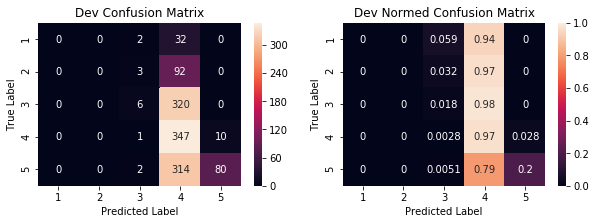

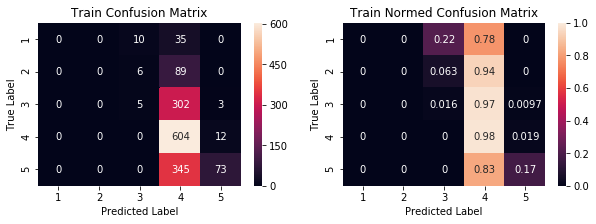

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

labels = [1, 2, 3, 4, 5]

for df, name in zip([dev, train], ["Dev", "Train"]):
    cm = confusion_matrix(list(df["gold"]), list(df["prediction"]))
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)

    f,(ax1,ax2) = plt.subplots(1,2,sharey=False, figsize=(10,3))
    g1 = sns.heatmap(df_cm,annot=True, fmt='d', ax=ax1)
    g1.set_ylabel('True Label')
    g1.set_xlabel('Predicted Label')
    g1.set_title(f'{name} Confusion Matrix')

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm_norm = pd.DataFrame(cm_norm, index=labels, columns=labels)
    g2 = sns.heatmap(df_cm_norm,annot=True, vmin=0, vmax=1, ax=ax2)
    g2.set_ylabel('True Label')
    g2.set_xlabel('Predicted Label')
    g2.set_title(f'{name} Normed Confusion Matrix')